# Import Libraries

In [16]:
!pip install pandas

   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/11.6 MB 8.3 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/11.6 MB 10.2 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.6 MB 10.4 MB/s eta 0:00:01
   ----------------------------- ---------- 8.7/11.6 MB 10.7 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.6 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 6.3 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Configuration

In [2]:
SEQ_LEN = 200 
EMBED_DIM = 64
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Load ADFA-LD Dataset

In [3]:
def load_syscall_sequences(folder):
    sequences = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        with open(path, 'r') as f:
            content = f.read().strip().split()
            seq = [int(s) for s in content]
            sequences.append(seq)
    return sequences

# Preprocessing

In [4]:
def pad_sequences(sequences, maxlen, pad_value=0):
    padded = []
    for seq in sequences:
        if len(seq) < maxlen:
            seq = seq + [pad_value] * (maxlen - len(seq))
        else:
            seq = seq[:maxlen]
        padded.append(seq)
    return np.array(padded)

# Custom Dataset

In [5]:
class SyscallDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.LongTensor(sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]
        return x, x

# Transformer Autoencoder code

In [6]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, seq_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.randn(seq_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, vocab_size)
        )

    def forward(self, x):
        x_embed = self.embedding(x) + self.positional_encoding.unsqueeze(0)
        encoded = self.encoder(x_embed)
        decoded = self.decoder(encoded)
        return decoded

# Training Code

In [7]:
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for x, target in dataloader:
            x, target = x.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")

# Inference and Anamoly Detection

In [8]:
def calculate_reconstruction_error(model, data_tensor):
    model.eval()
    with torch.no_grad():
        input_data = data_tensor.to(device)
        output = model(input_data)
        loss_fn = nn.CrossEntropyLoss(reduction='none')
        loss = loss_fn(output.view(-1, vocab_size), input_data.view(-1))
        seq_loss = loss.view(input_data.size(0), -1).mean(dim=1)
    return seq_loss.cpu().numpy()

# Plot Graphs

In [9]:
def plot_precision_recall_curve(val_errors, attack_errors):
    y_true = [0]*len(val_errors) + [1]*len(attack_errors)
    y_scores = np.concatenate([val_errors, attack_errors])
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()

def plot_roc_curve(val_errors, attack_errors):
    y_true = [0]*len(val_errors) + [1]*len(attack_errors)
    y_scores = np.concatenate([val_errors, attack_errors])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


# CSV results

In [10]:
def export_results(y_true, y_pred, val_errors, attack_errors, filename="results.csv"):
    y_scores = np.concatenate([val_errors, attack_errors])
    labels = ["Normal"]*len(val_errors) + ["Attack"]*len(attack_errors)
    df = pd.DataFrame({
        'True_Label': y_true,
        'Predicted_Label': y_pred,
        'Error_Score': y_scores,
        'Class': labels
    })
    df.to_csv(filename, index=False)
    print(f"Exported results to {filename}")

# Classification Metrics

In [11]:
def evaluate_threshold_metrics(val_errors, attack_errors, threshold):
    y_true = [0]*len(val_errors) + [1]*len(attack_errors)
    y_pred = [1 if score >= threshold else 0 for score in np.concatenate([val_errors, attack_errors])]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)
    print("Accuracy:", acc)
    print("F1-Score:", f1)
    return y_true, y_pred

# Time to run main function

C:\Users\vspil\anaconda3\envs\adfa_env\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 - Loss: 106.1661
Epoch 2/10 - Loss: 37.4259
Epoch 3/10 - Loss: 15.1017
Epoch 4/10 - Loss: 9.5839
Epoch 5/10 - Loss: 6.2962
Epoch 6/10 - Loss: 4.7261
Epoch 7/10 - Loss: 3.8047
Epoch 8/10 - Loss: 2.4817
Epoch 9/10 - Loss: 1.6946
Epoch 10/10 - Loss: 1.2883

Mean Reconstruction Error (Normal Validation): 0.06773324
Mean Reconstruction Error (Attacks): 0.51331246


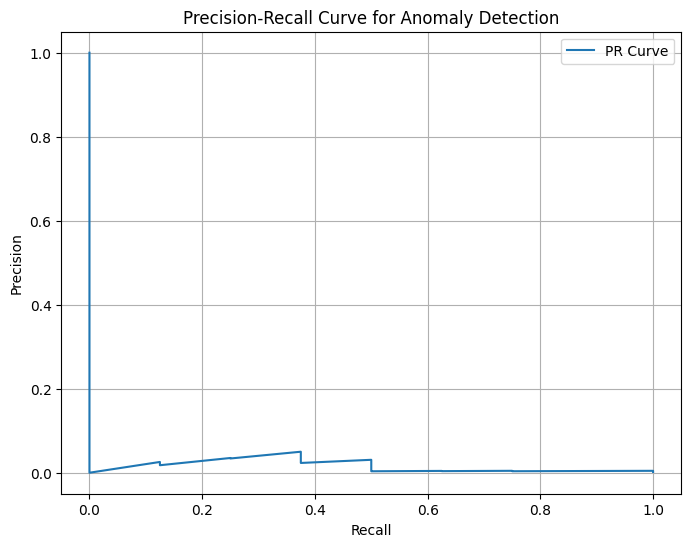


Confusion Matrix:
 [[4170  202]
 [   4    4]]
Accuracy: 0.9529680365296803
F1-Score: 0.037383177570093455


In [14]:
if __name__ == '__main__':
    train_folder = "ADFA-LD/ADFA-LD/Training_Data_Master"
    val_folder = "ADFA-LD/ADFA-LD/Validation_Data_Master"
    attack_folder = "ADFA-LD/ADFA-LD/Attack_Data_Master/Adduser_2"  # sample attack class

    train_seqs = load_syscall_sequences(train_folder)
    val_seqs = load_syscall_sequences(val_folder)
    attack_seqs = load_syscall_sequences(attack_folder)

    all_seqs = train_seqs + val_seqs + attack_seqs
    max_syscall = max(max(seq) for seq in all_seqs)
    vocab_size = max_syscall + 1

    train_data = pad_sequences(train_seqs, SEQ_LEN)
    val_data = pad_sequences(val_seqs, SEQ_LEN)
    attack_data = pad_sequences(attack_seqs, SEQ_LEN)

    train_dataset = SyscallDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerAutoencoder(vocab_size, EMBED_DIM, SEQ_LEN).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    train_model(model, train_loader, optimizer, criterion)

    val_tensor = torch.LongTensor(val_data)
    attack_tensor = torch.LongTensor(attack_data)

    val_errors = calculate_reconstruction_error(model, val_tensor)
    attack_errors = calculate_reconstruction_error(model, attack_tensor)

    print("\nMean Reconstruction Error (Normal Validation):", np.mean(val_errors))
    print("Mean Reconstruction Error (Attacks):", np.mean(attack_errors))

    # Evaluation Plot
    plot_precision_recall_curve(val_errors, attack_errors)

    threshold = (np.mean(val_errors) + np.mean(attack_errors)) / 2
    evaluate_threshold_metrics(val_errors, attack_errors, threshold)


# Plot all

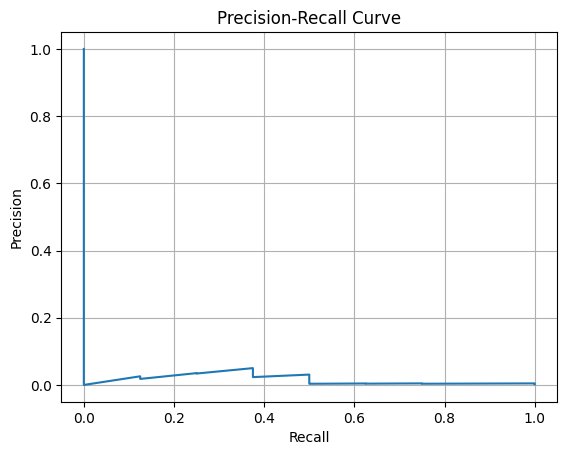

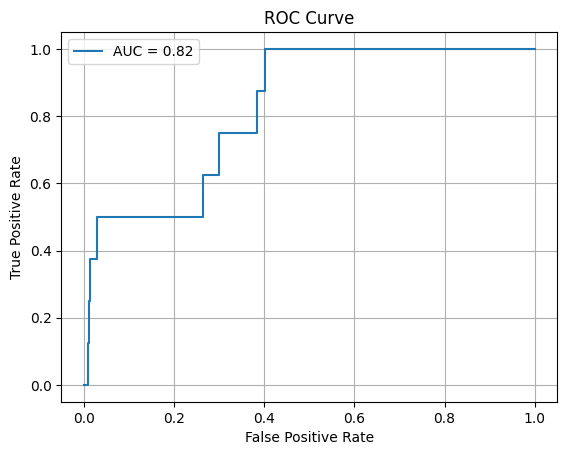

In [30]:

plot_precision_recall_curve(val_errors, attack_errors)
plot_roc_curve(val_errors, attack_errors)


In [33]:
y_true, y_pred = evaluate_threshold_metrics(val_errors, attack_errors, threshold)


Confusion Matrix:
 [[4170  202]
 [   4    4]]
Accuracy: 0.9529680365296803
F1-Score: 0.037383177570093455


In [34]:
 export_results(y_true, y_pred, val_errors, attack_errors)

Exported results to results.csv


# save model

In [35]:
def save_model(model, path="transformer_autoencoder_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"✅ Model saved to {path}")

In [36]:
save_model(model, "model.pth")

✅ Model saved to model.pth


# Load Model

In [37]:
def load_model(path, vocab_size, embed_dim, seq_len, device):
    model = TransformerAutoencoder(vocab_size, embed_dim, seq_len)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    print(f"✅ Model loaded from {path}")
    return model

In [38]:
model_loaded = load_model("model.pth", vocab_size, EMBED_DIM, SEQ_LEN, device)


✅ Model loaded from model.pth


C:\Users\vspil\anaconda3\envs\adfa_env\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Test model

In [40]:
def test_single_sequence(model, sequence, threshold):
    model.eval()
    sequence = pad_sequences([sequence], SEQ_LEN)
    sequence_tensor = torch.LongTensor(sequence).to(device)
    error = calculate_reconstruction_error(model, sequence_tensor)[0]
    print(f"Reconstruction Error: {error:.4f}")
    if error >= threshold:
        print("❌ Anomalous Sequence Detected")
    else:
        print("✅ Normal Sequence")

test_sequence = attack_seqs[1]  # or val_seqs[1] for normal
print("\nTesting loaded model on new input sequence:")
test_single_sequence(model_loaded, test_sequence, threshold)


Testing loaded model on new input sequence:
Reconstruction Error: 1.1701
❌ Anomalous Sequence Detected


# Enhanced model

In [12]:
class EnhancedTransformerAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, seq_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.randn(seq_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, dropout=0.2)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim * 2, vocab_size)
        )

    def forward(self, x):
        x_embed = self.embedding(x) + self.positional_encoding.unsqueeze(0)
        encoded = self.encoder(x_embed)
        decoded = self.decoder(encoded)
        return decoded

# Improved Training

In [13]:
def train_model_advanced(model, dataloader, optimizer, criterion, scheduler=None):
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for x, target in dataloader:
            x, target = x.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
            total_loss += loss.item()
        if scheduler:
            scheduler.step()
        print(f"[Optimized] Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")

# Dynamic Threshold Calculation

In [14]:
def get_dynamic_threshold(errors, factor=2):
    mean = np.mean(errors)
    std = np.std(errors)
    return mean + factor * std

# Model v2


📦 Loading Dataset

📦 Dataset Loaded

🔧 Training Upgraded EnhancedTransformerAutoencoder...


C:\Users\vspil\anaconda3\envs\adfa_env\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[Optimized] Epoch 1/10 - Loss: 111.2146
[Optimized] Epoch 2/10 - Loss: 55.6845
[Optimized] Epoch 3/10 - Loss: 36.3057
[Optimized] Epoch 4/10 - Loss: 31.3688
[Optimized] Epoch 5/10 - Loss: 29.4494
[Optimized] Epoch 6/10 - Loss: 28.6062
[Optimized] Epoch 7/10 - Loss: 27.8790
[Optimized] Epoch 8/10 - Loss: 27.6296
[Optimized] Epoch 9/10 - Loss: 27.7990
[Optimized] Epoch 10/10 - Loss: 27.2744

Confusion Matrix:
 [[4241  131]
 [   4    4]]
Accuracy: 0.9691780821917808
F1-Score: 0.055944055944055944


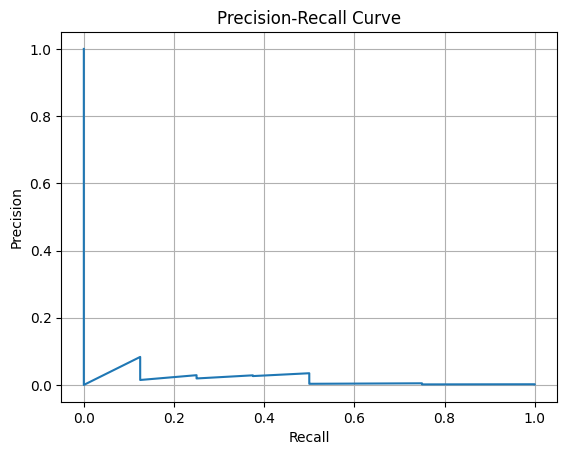

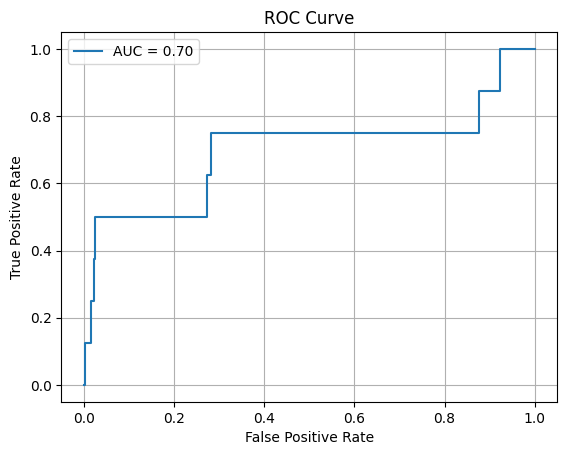

In [17]:
print("\n📦 Loading Dataset")
train_folder = "ADFA-LD/ADFA-LD/Training_Data_Master"
val_folder = "ADFA-LD/ADFA-LD/Validation_Data_Master"
attack_folder = "ADFA-LD/ADFA-LD/Attack_Data_Master/Adduser_2"
print("\n📦 Dataset Loaded")

train_seqs = load_syscall_sequences(train_folder)
val_seqs = load_syscall_sequences(val_folder)
attack_seqs = load_syscall_sequences(attack_folder)

all_seqs = train_seqs + val_seqs + attack_seqs
vocab_size = max(max(seq) for seq in all_seqs) + 1

train_data = pad_sequences(train_seqs, SEQ_LEN)
val_data = pad_sequences(val_seqs, SEQ_LEN)
attack_data = pad_sequences(attack_seqs, SEQ_LEN)

train_dataset = SyscallDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train enhanced model
print("\n🔧 Training Upgraded EnhancedTransformerAutoencoder...")
model_v2 = EnhancedTransformerAutoencoder(vocab_size, EMBED_DIM, SEQ_LEN).to(device)
optimizer_v2 = torch.optim.Adam(model_v2.parameters(), lr=LEARNING_RATE)
scheduler_v2 = torch.optim.lr_scheduler.StepLR(optimizer_v2, step_size=5, gamma=0.5)
criterion_v2 = nn.CrossEntropyLoss(label_smoothing=0.1)

train_model_advanced(model_v2, train_loader, optimizer_v2, criterion_v2, scheduler=scheduler_v2)

# Evaluation
val_tensor = torch.LongTensor(val_data)
attack_tensor = torch.LongTensor(attack_data)
val_errors_v2 = calculate_reconstruction_error(model_v2, val_tensor)
attack_errors_v2 = calculate_reconstruction_error(model_v2, attack_tensor)

threshold_v2 = get_dynamic_threshold(val_errors_v2, factor=2)
y_true_v2, y_pred_v2 = evaluate_threshold_metrics(val_errors_v2, attack_errors_v2, threshold_v2)

plot_precision_recall_curve(val_errors_v2, attack_errors_v2)
plot_roc_curve(val_errors_v2, attack_errors_v2)

# Optional: Save model
torch.save(model_v2.state_dict(), "enhanced_transformer_autoencoder.pth")